In [3]:
import sys
from pathlib import Path

# Add the 'backtest' directory to the system path
notebook_dir = Path().resolve()
backtest_dir = notebook_dir.parent / 'backtest'
sys.path.append(str(backtest_dir))

In [4]:
import pandas as pd
from backtest import Backtest, Strategy, TradeAction

In [5]:
# First run the get_data.ipynb notebook to generate the data file
# or copy the code from get_data.ipynb here to download the data directly

# Read the OHLCV data from data/BTCUSDT.csv
data = pd.read_csv('data/BTCUSDT.csv', index_col='Date', parse_dates=True)

In [6]:
class SmaCrossStrategy(Strategy):

    def __init__(self):
        self.sma_short = 10
        self.sma_long = 40

    def on_candle(self, historical_data, positions_list):
        open_positions = [p for p in positions_list if p.exit_time is None]
        data_with_smas = self.get_data_with_smas(historical_data)
        if self.has_positive_crossing(data_with_smas):
            # Open a long position
            trade_actions = [TradeAction(action="enter", quantity=1)]
            # Close any existing positions
            if len(open_positions) > 0:
                trade_actions += [
                    TradeAction(action="exit", position_id=pos.id)
                    for pos in open_positions
                ]
            return trade_actions
        elif self.has_negative_crossing(data_with_smas):
            # Open a short position
            trade_actions = [TradeAction(action="enter", quantity=-1)]
            # Close any existing positions
            if len(open_positions) > 0:
                trade_actions += [
                    TradeAction(action="exit", position_id=pos.id)
                    for pos in open_positions
                ]
            return trade_actions
        return []
    
    def get_data_with_smas(self, df: pd.DataFrame) -> pd.DataFrame:
        df = df.copy()
        df.loc[:, "sma_short"] = df["Close"].rolling(window=self.sma_short).mean()
        df.loc[:, "sma_long"] = df["Close"].rolling(window=self.sma_long).mean()
        return df

    def has_positive_crossing(self, df: pd.DataFrame) -> bool:
        if len(df) < self.sma_long:
            return False
        last_data = df.iloc[-1]
        prev_data = df.iloc[-2]
        return (last_data["sma_short"] > last_data["sma_long"]) & (
            prev_data["sma_short"] <= prev_data["sma_long"]
        )

    def has_negative_crossing(self, df: pd.DataFrame) -> bool:
        if len(df) < self.sma_long:
            return False
        last_data = df.iloc[-1]
        prev_data = df.iloc[-2]
        return (last_data["sma_short"] < last_data["sma_long"]) & (
            prev_data["sma_short"] >= prev_data["sma_long"]
        )

In [7]:
backtest = Backtest(data, SmaCrossStrategy)

backtest.run()

backtest.pnl_df

,Open,High,Low,Close,Volume,pos-1-pnl,pos-2-pnl,pos-3-pnl,pos-4-pnl,pos-5-pnl,...,pos-37-pnl,pos-38-pnl,pos-39-pnl,pos-40-pnl,pos-41-pnl,pos-42-pnl,pos-43-pnl,pos-44-pnl,pos-45-pnl,total_pnl
Date,,,,,,,,,,,,,,,,,,,,,
2020-01-01,7195.24,7255.00,7175.15,7200.85,16792.388165,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
2020-01-02,7200.77,7212.50,6924.74,6965.71,31951.483932,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
2020-01-03,6965.49,7405.00,6871.04,7344.96,68428.500451,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
2020-01-04,7345.00,7404.00,7272.21,7354.11,29987.974977,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
2020-01-05,7354.19,7495.00,7318.00,7358.75,38331.085604,0.00,0.00,0.00,0.00,0.00,...,0.00,0.0,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-10,82615.22,82753.21,78464.36,79607.30,33284.807180,1407.26,2075.41,-179.15,600.19,-787.15,...,-8026.63,-6271.3,-1964.65,-11117.97,-6926.0,31351.03,-7032.54,-4886.82,16837.45,92617.08
2025-04-11,79607.30,84300.00,78969.58,83423.84,34435.437970,1407.26,2075.41,-179.15,600.19,-787.15,...,-8026.63,-6271.3,-1964.65,-11117.97,-6926.0,31351.03,-7032.54,-4886.82,13020.91,88800.54
2025-04-12,83423.83,85905.00,82792.95,85276.90,18470.744370,1407.26,2075.41,-179.15,600.19,-787.15,...,-8026.63,-6271.3,-1964.65,-11117.97,-6926.0,31351.03,-7032.54,-4886.82,11167.85,86947.48


In [ ]:
stats = backtest.stats()

Backtest Statistics:
total_return: 17299.809999999998
max_drawdown: -46580.58
sharpe_ratio: 0.010265037321142765
num_trades: 32
win_rate: 0.28125
avg_win: 11423.59888888889
avg_loss: -3717.9382608695646


In [8]:
# Extract long positions (quantity >= 0 or value >= 0)
long_positions = [pos for pos in backtest.positions if pos.quantity >= 0]
# Create a series of long positions entry "Open" prices from backtest.pnl_df
long_entry_series = backtest.pnl_df.loc[[pos.entry_time for pos in long_positions], 'Open']

# Extract short positions (quantity < 0 or value < 0)
short_positions = [pos for pos in backtest.positions if pos.quantity < 0]
# Create a series of short position entry "Open" prices from backtest.pnl_df
short_entry_series = backtest.pnl_df.loc[[pos.entry_time for pos in short_positions], 'Open']

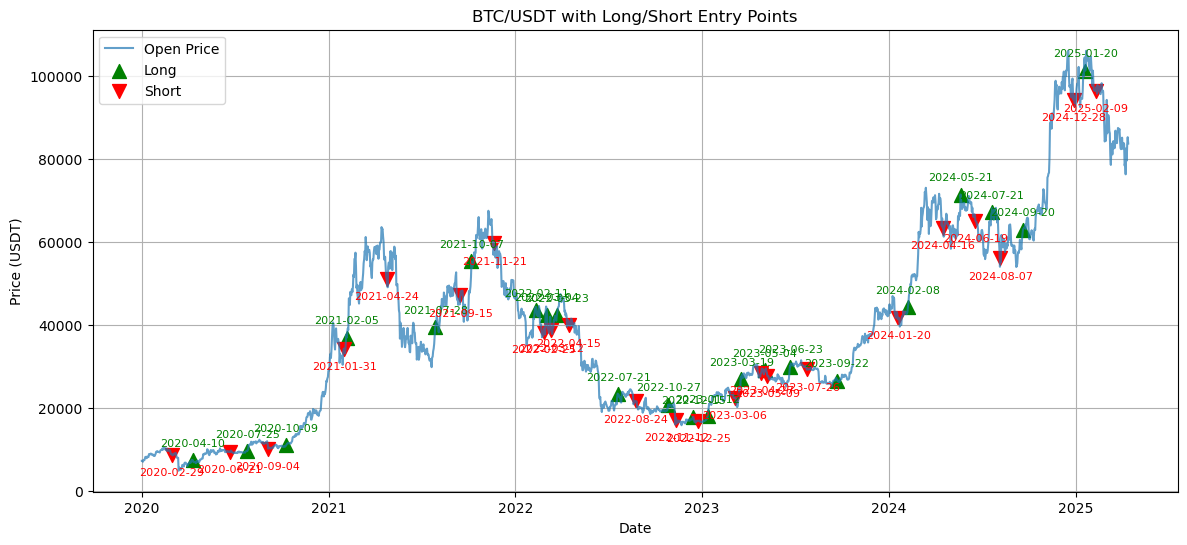

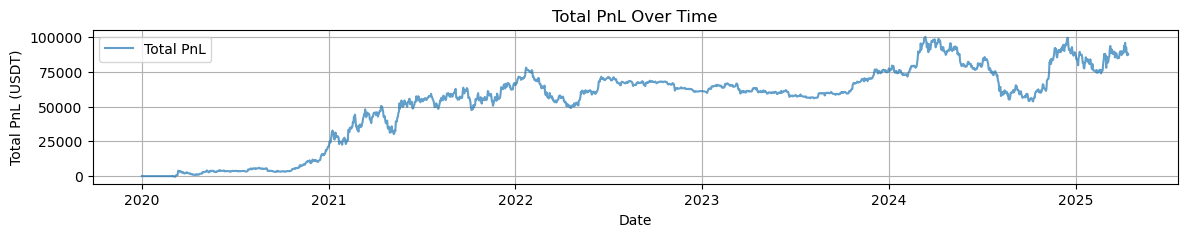

In [9]:
from matplotlib import pyplot as plt

df = backtest.pnl_df

plt.figure(figsize=(14, 6))
plt.plot(df['Open'], label="Open Price", alpha=0.7)

plt.scatter(long_entry_series.index, long_entry_series, marker='^', color="green", label="Long", s=100)

plt.scatter(short_entry_series.index, short_entry_series, marker='v', color="red", label="Short", s=100)

for idx, price in long_entry_series.items():
    plt.annotate(idx.strftime('%Y-%m-%d'), xy=(idx, price), xytext=(0, 10), 
                 textcoords='offset points', ha='center', fontsize=8, color='green')
    
for idx, price in short_entry_series.items():
    plt.annotate(idx.strftime('%Y-%m-%d'), xy=(idx, price), xytext=(0, -15), 
                 textcoords='offset points', ha='center', fontsize=8, color='red')

plt.title("BTC/USDT with Long/Short Entry Points")
plt.xlabel('Date')
plt.ylabel('Price (USDT)')
plt.legend()
plt.grid(True)
plt.show()

# Plot the Total PnL
plt.figure(figsize=(14, 2))
plt.plot(df['total_pnl'], label="Total PnL", alpha=0.7)
plt.title("Total PnL Over Time")
plt.xlabel('Date')
plt.ylabel('Total PnL (USDT)')
plt.legend()
plt.grid(True)
plt.show()